# Model Building

In [52]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

drive_dir = "/content/drive/My Drive"
mount_dir = os.path.join(drive_dir, "Colab Notebooks")
base_dir = os.getcwd()
data_dir = os.path.join(drive_dir, "Test Data/RadiomicFeatures.csv")

Mounted at /content/drive


## 1. Data Preproccesing

In [88]:
# load data set
features_data = pd.read_csv(data_dir)
features_data.head()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance
0,0.527583,0.513377,57.283694,111.582079,114.212590,115.152790,73.284082,122.643745,237540.783691,58.868845,...,17.019354,0.011378,489.785185,0.403115,0.658978,136.257830,0.007516,6.080010,0.180107,3255.880190
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.521267,0.446565,45.221860,101.266101,113.592903,100.020486,60.776486,113.771650,164111.006592,52.786691,...,39.427170,0.014237,1231.206019,0.382006,0.641698,130.008726,0.007626,6.319431,0.143800,10372.099039
3,0.565475,0.449311,46.427784,103.331131,113.553247,112.623081,68.007353,115.767666,194060.038535,58.431183,...,26.608202,0.020693,1239.888344,0.433983,0.685239,89.661381,0.013659,5.961805,0.161058,5504.858331
4,0.485448,0.407476,42.413620,104.088690,111.060812,106.570473,58.235949,111.219413,154694.140625,50.529691,...,13.131031,0.015890,1038.289971,0.377286,0.636561,129.422304,0.008716,6.460849,0.150145,4201.871850


In [89]:
# create outcome variable
HCC = np.concatenate((np.zeros(20), np.ones(20)), axis=0)
features_data['HCC'] = HCC.tolist()

In [90]:
# create feature only dataset
features_only = features_data.drop(['HCC'], axis=1)

# remove rows with all 0s
features_only = features_only.loc[~(features_only==0).all(axis=1)]
features_only.shape # 34 rows remaining

(34, 72)

In [91]:
# remove constant features
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(features_only)
constant_columns = [column for column in features_only.columns
                    if column not in features_only.columns[constant_filter.get_support()]]
features_only.drop(labels=constant_columns, axis=1, inplace=True)
features_only.shape

(34, 72)

In [92]:
# remove quasi constant features
qconstant_filter = VarianceThreshold(threshold=0.001)
qconstant_filter.fit(features_only)
qconstant_columns = [column for column in features_only.columns
                     if column not in features_only.columns[qconstant_filter.get_support()]]
features_only.drop(labels=qconstant_columns, axis=1, inplace=True)
features_only.shape

(34, 64)

In [93]:
# get column names
features_names = list(features_only.columns)
len(features_names)

64

In [94]:
# z-score standardize predictors
scaler = StandardScaler()
features_only = scaler.fit_transform(features_only)

In [96]:
# drop missing columns from full dataset
features_data = pd.DataFrame(features_only, columns=features_names)
features_data.describe()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance
count,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,...,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01,3.400000e+01
mean,-2.612289e-16,-1.959217e-17,7.142979e-17,1.502066e-16,4.898043e-16,-5.779690e-16,-1.436759e-15,-3.787820e-16,3.983741e-16,1.410636e-15,...,5.224579e-17,2.612289e-17,-1.306145e-17,-3.510264e-16,-9.143013e-17,7.183796e-17,-1.502066e-16,-5.120087e-15,4.636814e-16,2.612289e-17
std,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,...,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00,1.015038e+00
min,-1.148182e+00,-3.260448e+00,-3.473615e+00,-2.336496e+00,-3.170851e+00,-2.511451e+00,-2.174034e+00,-2.594873e+00,-2.621423e+00,-3.823711e+00,...,-4.547636e-01,-4.946716e-01,-4.306893e-01,-1.572193e+00,-2.655322e+00,-2.903951e+00,-1.605182e+00,-1.460971e+00,-2.213877e+00,-4.546963e-01
25%,-5.564567e-01,-2.248139e-01,5.627738e-02,-3.378943e-01,-3.442385e-01,-4.720706e-01,-6.794115e-01,-2.309861e-01,-4.263458e-01,-5.415078e-01,...,-4.288544e-01,-4.403859e-01,-4.173874e-01,-5.546738e-01,-2.033570e-01,-1.488581e-01,-6.367310e-01,-7.575999e-01,-6.112481e-01,-4.288786e-01
50%,-3.462991e-01,6.801638e-02,2.125222e-01,2.870795e-01,2.126530e-01,3.114764e-01,9.258825e-02,1.845624e-01,1.017159e-01,7.326617e-02,...,-3.640228e-01,-3.673394e-01,-3.805225e-01,-2.144922e-01,2.291051e-01,2.613933e-01,-1.149277e-01,-2.613496e-01,7.948599e-02,-3.639258e-01
75%,1.858897e-01,3.174110e-01,4.431269e-01,5.119120e-01,4.972583e-01,4.885192e-01,8.263268e-01,5.547126e-01,6.321590e-01,7.354036e-01,...,-2.704705e-01,-2.642928e-01,-2.520560e-01,4.154065e-01,6.180830e-01,6.069919e-01,3.566234e-01,4.271352e-01,8.499347e-01,-2.707631e-01
max,2.799634e+00,1.988186e+00,1.389265e+00,1.920127e+00,1.644534e+00,2.515668e+00,1.634771e+00,2.676888e+00,1.963715e+00,1.555968e+00,...,3.774310e+00,3.974646e+00,3.399062e+00,3.966781e+00,1.471944e+00,1.335931e+00,2.765209e+00,3.396608e+00,1.646570e+00,3.771671e+00


In [97]:
HCC = np.concatenate((np.zeros(14), np.ones(20)), axis=0)
features_data['HCC'] = HCC.tolist()

In [133]:
# remove correlated features
def corrX(df, outcome, cut = 0.85) :

    # create storage space
    bi_corr = np.zeros((len(features_data.columns),2))
    df_notarget = df.drop([outcome], axis=1)
    drop = list()
        
    # get correlation matrix and upper triagle
    corr_mtx = df_notarget.corr().abs()
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
  
    # get point biserial correlation with outcome variable
    for idx, column in enumerate(df.columns):
      bi_corr[idx] = stats.pointbiserialr(df[column], df[outcome])
    
    # drop column with p-values
    bi_corr = np.delete(bi_corr, -1, axis=1)

		# loop over correlation matrix and remove features 
    # based on point-biserial correlation with outcome
    for row in range(len(up)-1):
      col_idx = row + 1
      for col in range (col_idx, len(up)):
        if(corr_mtx.iloc[row, col] > cut):
          if(bi_corr[row] > bi_corr[col]): 
            drop.append(row)
          else: 
            drop.append(col)
    
    drop_set = list(set(drop))
    dropcols_names = list(features_data.columns[[item for item in drop_set]])
    
    return(dropcols_names)

In [134]:
drop_features = corrX(features_data, 'HCC')
drop_features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


['original_shape_LeastAxisLength',
 'original_shape_MajorAxisLength',
 'original_shape_Maximum2DDiameterColumn',
 'original_shape_Maximum2DDiameterRow',
 'original_shape_Maximum3DDiameter',
 'original_shape_MeshVolume',
 'original_shape_VoxelVolume',
 'original_firstorder_10Percentile',
 'original_firstorder_90Percentile',
 'original_firstorder_Entropy',
 'original_firstorder_InterquartileRange',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_Mean',
 'original_firstorder_Median',
 'original_firstorder_Range',
 'original_firstorder_RobustMeanAbsoluteDeviation',
 'original_firstorder_RootMeanSquared',
 'original_firstorder_TotalEnergy',
 'original_firstorder_Variance',
 'original_glcm_Autocorrelation',
 'original_glcm_ClusterProminence',
 'original_glcm_ClusterTendency',
 'original_glcm_Contrast',
 'original_glcm_DifferenceAverage',
 'original_glcm_DifferenceEntropy',
 'original_glcm_Idm',
 'original_glcm_InverseVariance',
 'original_glcm_JointAverage',
 'original_gl

In [138]:
features_data = features_data.drop(drop_features, axis=1)
features_only = features_data.drop(['HCC'], axis=1)

## 2. Exploratory Analysis

In [139]:
correlations = features_only.corr()
dissimilarity = 1 - abs(correlations)
Z = linkage(squareform(dissimilarity), 'complete')

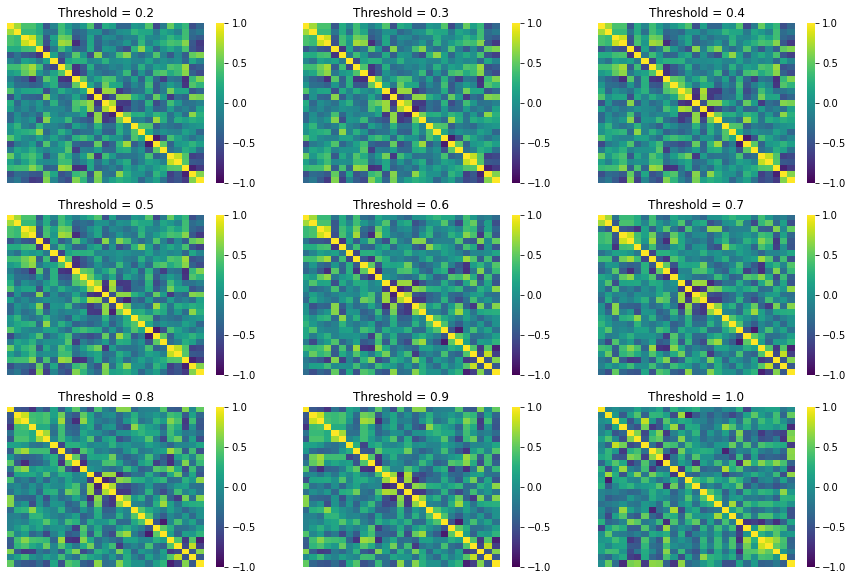

In [140]:
plt.figure(figsize=(15,10))

for idx, threshold in enumerate(np.arange(0.2,1.1,0.1)):
    
    # Subplot idx + 1
    plt.subplot(3, 3, idx+1)
    
    # Calculate the cluster
    labels = fcluster(Z, threshold, criterion='distance')

    # Keep the indices to sort labels
    labels_order = np.argsort(labels)

    # Build a new dataframe with the sorted columns
    for idx, i in enumerate(features_data.columns[labels_order]):
        if idx == 0:
            clustered = pd.DataFrame(features_data[i])
        else:
            df_to_append = pd.DataFrame(features_data[i])
            clustered = pd.concat([clustered, df_to_append], axis=1)
            
    # Plot the correlation heatmap
    correlations = clustered.corr()
    sns.heatmap(round(correlations,2), cmap='viridis', vmin=-1, vmax=1, 
                xticklabels=False, yticklabels=False)
    plt.title("Threshold = {}".format(round(threshold,2)))


## 3. Model Building

### 3.1 Using sklearn

In [161]:
# divide data set in 50%:50% split
X = features_only # Features
y = features_data['HCC'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=16)

In [162]:
from sklearn.model_selection import GridSearchCV
param = {'C':np.logspace(-5,5,11), 'penalty':['l1'], 'solver':['liblinear']}
logreg = LogisticRegression(random_state=16)
logreg_cv = GridSearchCV(logreg, param, cv=5, scoring='accuracy')
logreg_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=16),
             param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]),
                         'penalty': ['l1'], 'solver': ['liblinear']},
             scoring='accuracy')

In [163]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("best score :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
best score : 0.6833333333333333


In [164]:
res = pd.DataFrame(logreg_cv.cv_results_)
res.iloc[:,res.columns.str.contains("split[0-9]_test_score|params",regex=True)]

,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,"{'C': 1e-05, 'penalty': 'l1', 'solver': 'libli...",0.50,0.50,0.333333,0.333333,0.333333
1,"{'C': 0.0001, 'penalty': 'l1', 'solver': 'libl...",0.50,0.50,0.333333,0.333333,0.333333
2,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",0.50,0.50,0.333333,0.333333,0.333333
3,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.50,0.50,0.333333,0.333333,0.333333
4,"{'C': 0.1, 'penalty': 'l1', 'solver': 'libline...",0.50,0.50,0.333333,0.333333,0.333333
5,"{'C': 1.0, 'penalty': 'l1', 'solver': 'libline...",1.00,0.75,0.333333,0.333333,1.000000
6,"{'C': 10.0, 'penalty': 'l1', 'solver': 'liblin...",0.75,0.50,0.333333,0.333333,0.666667
7,"{'C': 100.0, 'penalty': 'l1', 'solver': 'libli...",0.50,0.75,0.333333,0.666667,0.666667
8,"{'C': 1000.0, 'penalty': 'l1', 'solver': 'libl...",0.50,0.75,0.333333,0.666667,0.666667
9,"{'C': 10000.0, 'penalty': 'l1', 'solver': 'lib...",0.25,0.75,0.333333,0.333333,1.000000


In [165]:
mod = LogisticRegression(penalty='l1', C=1, solver='liblinear', random_state=16).fit(X_train, y_train)
pred = mod.predict(X_test)
mod.score(X_test, y_test) # accuracy = 0.88

0.8823529411764706

In [172]:
# get coefficients
print(mod.coef_) # feature 0, 9, 10, 13, and 14 remain

[[-1.23688391  0.          0.          0.          0.          0.
   0.          0.          0.          0.69339467  0.13436324  0.
   0.         -0.24922804  0.59201195  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]


In [167]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, pred)
cnf_matrix

array([[6, 1],
       [1, 9]])

In [168]:
from sklearn.metrics import classification_report

labels = ['no HCC', 'HCC']
print(classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

      no HCC       0.86      0.86      0.86         7
         HCC       0.90      0.90      0.90        10

    accuracy                           0.88        17
   macro avg       0.88      0.88      0.88        17
weighted avg       0.88      0.88      0.88        17



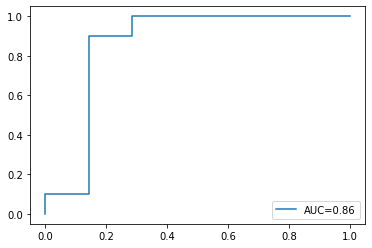

In [180]:
# plot ROC-curve
pred_proba = mod.predict_proba(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, pred_proba[:,1])
auc = metrics.roc_auc_score(y_test, pred_proba[:,1])
plt.plot(fpr,tpr,label="AUC="+str(np.around(auc, decimals=2)))
plt.legend(loc=4)
plt.show()

### 3.2 Using statsmodel

In [178]:
import statsmodels.api as sm
mod2 = sm.Logit(y_train, X_train)
res = mod2.fit_regularized(method='l1', alpha=1)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4746987649240541
            Iterations: 34
            Function evaluations: 34
            Gradient evaluations: 34


In [179]:
# coefficients are slightly different to sklearn but p-values included
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                       Results: Logit
============================================================================================
Model:                         Logit                     Pseudo R-squared:          0.551   
Dependent Variable:            HCC                       AIC:                       20.3366 
Date:                          2022-11-22 13:32          BIC:                       24.5026 
No. Observations:              17                        Log-Likelihood:            -5.1683 
Df Model:                      4                         LL-Null:                   -11.517 
Df Residuals:                  12                        LLR p-value:               0.012848
Converged:                     1.0000                    Scale:                     1.0000  
No. Iterations:                34.0000                                                      
--------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
--------------------------------------------------------------------------------------------
original_shape_Elongation                     -1.2552   0.9313 -1.3477 0.1777 -3.0806 0.5702
original_shape_Flatness                        0.0000      nan     nan    nan     nan    nan
original_shape_Maximum2DDiameterSlice          0.0000      nan     nan    nan     nan    nan
original_shape_MinorAxisLength                 0.0000      nan     nan    nan     nan    nan
original_shape_Sphericity                      0.0000      nan     nan    nan     nan    nan
original_shape_SurfaceArea                     0.0000      nan     nan    nan     nan    nan
original_shape_SurfaceVolumeRatio              0.0000      nan     nan    nan     nan    nan
original_firstorder_Energy                     0.0000      nan     nan    nan     nan    nan
original_firstorder_Kurtosis                   0.0000      nan     nan    nan     nan    nan
original_firstorder_Maximum                    0.7047   0.5974  1.1796 0.2382 -0.4662 1.8755
original_firstorder_Minimum                    0.1048   0.9948  0.1053 0.9161 -1.8450 2.0545
original_firstorder_Skewness                   0.0000      nan     nan    nan     nan    nan
original_glcm_ClusterShade                     0.0000      nan     nan    nan     nan    nan
original_glcm_Correlation                     -0.2746   0.7561 -0.3632 0.7164 -1.7565 1.2073
original_glcm_DifferenceVariance               0.5623   0.8997  0.6250 0.5320 -1.2010 2.3256
original_glcm_Id                               0.0000      nan     nan    nan     nan    nan
original_glcm_Imc1                             0.0000      nan     nan    nan     nan    nan
original_glcm_Imc2                             0.0000      nan     nan    nan     nan    nan
original_glcm_SumEntropy                       0.0000      nan     nan    nan     nan    nan
original_glszm_GrayLevelNonUniformity          0.0000      nan     nan    nan     nan    nan
original_glszm_GrayLevelVariance               0.0000      nan     nan    nan     nan    nan
original_glszm_HighGrayLevelZoneEmphasis       0.0000      nan     nan    nan     nan    nan
original_glszm_LargeAreaHighGrayLevelEmphasis  0.0000      nan     nan    nan     nan    nan
original_glszm_SizeZoneNonUniformity           0.0000      nan     nan    nan     nan    nan
original_glszm_SmallAreaEmphasis               0.0000      nan     nan    nan     nan    nan
original_glszm_ZoneEntropy                     0.0000      nan     nan    nan     nan    nan
original_glszm_ZonePercentage                  0.0000      nan     nan    nan     nan    nan
============================================================================================

"""